# Logistic Regression Analysis for Course Difficulty Prediction

## Overview
This analysis implements a supervised learning approach to predict course difficulty using logistic regression. We will:
1. Manually define "difficult" vs "easy" courses based on a SET evaluation feature
2. Use these labels as ground truth
3. Build a logistic regression model to predict difficulty
4. Analyze model performance and feature contributions

**Data Sources:**
- **SET data**: Student Evaluation of Teaching (recent evaluations) - **ONLY DATA SOURCE**
- **Note**: This analysis uses SET data exclusively.

In [33]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical and machine learning libraries
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr, spearmanr
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.inspection import permutation_importance

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [ ]:
# Load SET data (ONLY data source - no WebReg)
print("Loading SET data...")
dsc_sets = pd.read_csv('datasets/dsc_sets.csv')
print(f"SET data loaded: {len(dsc_sets)} rows, {dsc_sets.shape[1]} columns")
print(f"SET columns: {list(dsc_sets.columns)}")
print("\nNote: This analysis uses ONLY SET data.")

Loading SET data...
SET data loaded: 147 rows, 11 columns
SET columns: ['Instructor', 'Course', 'Term', 'Enrolled/ Resp Rate', 'Avg Grade Received', 'Avg Hours Worked', 'Learning Average*', 'Structure Average*', 'Environment Average*', 'course_title', 'Enrolled/  Resp Rate']

Note: Part 1 uses ONLY SET data. WebReg integration will be handled in Part 2.


## Step 2: Data Cleaning and Feature Engineering

We need to:
1. Extract course numbers from course titles
2. Standardize term formats
3. Clean and extract numeric values from grade fields
4. Aggregate SET data by course and quarter
5. Create derived features for analysis

**Note:** This analysis uses ONLY SET data. No WebReg data is used.

In [ ]:
# Helper function to extract course number from course title
def extract_course_number(course_title):
    """Extract numeric course number from course title (e.g., 'dsc100' -> 100)"""
    if pd.isna(course_title):
        return None
    import re
    match = re.search(r'dsc(\d+)', str(course_title).lower())
    if match:
        return int(match.group(1))
    return None

# Helper function to standardize term format
def standardize_term(term):
    """Convert term format to match webreg format (e.g., 'FA24' -> 'fa24')"""
    if pd.isna(term):
        return None
    term_str = str(term).upper()
    term_map = {
        'FA24': 'fa24', 'WI25': 'wi25', 'SP25': 'sp25',
        'FALL 2024': 'fa24', 'WINTER 2025': 'wi25', 'SPRING 2025': 'sp25',
        'FA 2024': 'fa24', 'WI 2025': 'wi25', 'SP 2025': 'sp25'
    }
    if term_str in term_map:
        return term_map[term_str]
    import re
    match = re.search(r'(FA|WI|SP|FALL|WINTER|SPRING)\s*(\d{2,4})', term_str)
    if match:
        season = match.group(1)[:2].upper()
        year = match.group(2)[-2:]
        if season.startswith('FA'):
            return f'fa{year}'
        elif season.startswith('WI'):
            return f'wi{year}'
        elif season.startswith('SP'):
            return f'sp{year}'
    return None

# Clean SET data (ONLY data source)
print("Cleaning SET data...")

# First, clean column names (before creating new columns)
dsc_sets.columns = dsc_sets.columns.str.replace('*', '', regex=False)
dsc_sets.columns = dsc_sets.columns.str.replace(' ', '_')
dsc_sets.columns = dsc_sets.columns.str.replace('/', '_')

# Handle Enrolled Resp Rate columns (merge duplicates)
if "Enrolled_Resp_Rate" in dsc_sets.columns and "Enrolled__Resp_Rate" in dsc_sets.columns:
    dsc_sets["Enrolled_Resp_Rate"] = dsc_sets["Enrolled_Resp_Rate"].fillna(dsc_sets["Enrolled__Resp_Rate"])
    dsc_sets = dsc_sets.drop(columns=["Enrolled__Resp_Rate"], errors='ignore')
elif "Enrolled_Resp_Rate" in dsc_sets.columns:
    pass  # Already exists
elif "Enrolled__Resp_Rate" in dsc_sets.columns:
    dsc_sets["Enrolled_Resp_Rate"] = dsc_sets["Enrolled__Resp_Rate"]
    dsc_sets = dsc_sets.drop(columns=["Enrolled__Resp_Rate"], errors='ignore')

# Drop unnecessary columns first
dsc_sets = dsc_sets.drop(columns=["Course"], errors='ignore')

# Handle duplicate columns BEFORE converting to numeric
# Find all duplicate column names
print(f"\nColumns before removing duplicates: {len(dsc_sets.columns)}")
all_cols = list(dsc_sets.columns)
duplicate_cols = [col for col in set(all_cols) if all_cols.count(col) > 1]
print(f"Duplicate column names found: {duplicate_cols}")

# For each duplicate column, merge them intelligently (keep non-NaN values)
for col_name in duplicate_cols:
    col_indices = [i for i, c in enumerate(dsc_sets.columns) if c == col_name]
    if len(col_indices) > 1:
        print(f"  Merging duplicate '{col_name}' columns (indices: {col_indices})")
        # Get all columns with this name
        cols_data = [dsc_sets.iloc[:, idx] for idx in col_indices]
        
        # Merge: start with first column, fill NaN with values from other columns
        merged_col = cols_data[0].copy()
        for other_col in cols_data[1:]:
            # Fill NaN values with non-NaN values from other column
            mask = merged_col.isna() & other_col.notna()
            merged_col[mask] = other_col[mask]
        
        # Replace first occurrence with merged data
        dsc_sets.iloc[:, col_indices[0]] = merged_col
        
        # Drop all other occurrences
        cols_to_drop = [dsc_sets.columns[i] for i in col_indices[1:]]
        dsc_sets = dsc_sets.drop(columns=cols_to_drop, errors='ignore')
        
        # Rename to ensure consistency (in case pandas kept different names)
        dsc_sets = dsc_sets.rename(columns={dsc_sets.columns[col_indices[0]]: col_name})

# Now remove any remaining duplicates by position
dsc_sets = dsc_sets.loc[:, ~dsc_sets.columns.duplicated(keep='first')]

# Verify duplicates are removed
print(f"Columns after removing duplicates: {len(dsc_sets.columns)}")
remaining_duplicates = [col for col in set(dsc_sets.columns) if list(dsc_sets.columns).count(col) > 1]
if remaining_duplicates:
    print(f"Warning: Still have duplicate columns: {remaining_duplicates}")
    # Force remove by recreating dataframe with unique columns
    dsc_sets = dsc_sets.iloc[:, ~dsc_sets.columns.duplicated(keep='first')]
else:
    print("✓ All duplicate columns removed successfully")
print(f"Final column names: {list(dsc_sets.columns)}")

# NOW extract numeric grade from Avg_Grade_Received (after duplicates are removed)
if "Avg_Grade_Received" in dsc_sets.columns:
    # Get the column as a Series (should be unique now)
    col_idx = list(dsc_sets.columns).index("Avg_Grade_Received")
    col_series = dsc_sets.iloc[:, col_idx]
    
    # Check if column contains strings (like "3.93 (A-)") or is already numeric
    if col_series.dtype == 'object':
        # Extract numeric GPA value from strings like "3.93 (A-)" or "3.93"
        # Pattern matches: start of string, digits, optional decimal point and more digits
        extracted = col_series.astype(str).str.extract(r'^(\d+\.?\d*)', expand=False)
        dsc_sets.iloc[:, col_idx] = pd.to_numeric(extracted, errors='coerce')
        non_null_count = dsc_sets.iloc[:, col_idx].notna().sum()
        print(f"  Extracted numeric grades from Avg_Grade_Received: {non_null_count} non-null values")
    else:
        # Already numeric, just ensure it's the right type
        dsc_sets.iloc[:, col_idx] = pd.to_numeric(col_series, errors='coerce')
        print(f"  Converted Avg_Grade_Received to numeric: {dsc_sets.iloc[:, col_idx].notna().sum()} non-null values")
else:
    # Try alternative names
    for col in dsc_sets.columns:
        if 'Grade' in col and 'Received' in col:
            col_idx = list(dsc_sets.columns).index(col)
            col_series = dsc_sets.iloc[:, col_idx]
            if col_series.dtype == 'object':
                # Extract numeric values from strings like "3.93 (A-)"
                extracted = col_series.astype(str).str.extract(r'^(\d+\.?\d*)', expand=False)
                dsc_sets.iloc[:, col_idx] = pd.to_numeric(extracted, errors='coerce')
            else:
                dsc_sets.iloc[:, col_idx] = pd.to_numeric(col_series, errors='coerce')
            # Rename to Avg_Grade_Received
            dsc_sets = dsc_sets.rename(columns={col: "Avg_Grade_Received"})
            print(f"  Extracted numeric grades from {col}: {dsc_sets.iloc[:, col_idx].notna().sum()} non-null values")
            break

# Extract course number and quarter
dsc_sets['course_number'] = dsc_sets['course_title'].apply(extract_course_number)
dsc_sets = dsc_sets[dsc_sets['course_number'].notna()]
dsc_sets['quarter'] = dsc_sets['Term'].apply(standardize_term)

print(f"\nSET cleaned: {len(dsc_sets)} evaluations")
print(f"SET columns after cleaning: {list(dsc_sets.columns)}")
print(f"\nSET data summary:")

# Safe function to get non-null count
def safe_nonnull_count(df, col_name):
    """Safely count non-null values in a column"""
    if col_name not in df.columns:
        return None
    try:
        col_idx = list(df.columns).index(col_name)
        col_data = df.iloc[:, col_idx]
        count = col_data.notna().sum()
        return int(count) if not isinstance(count, pd.Series) else int(count.iloc[0]) if len(count) > 0 else 0
    except:
        return None

hours_count = safe_nonnull_count(dsc_sets, 'Avg_Hours_Worked')
grade_count = safe_nonnull_count(dsc_sets, 'Avg_Grade_Received')
learning_count = safe_nonnull_count(dsc_sets, 'Learning_Average')
structure_count = safe_nonnull_count(dsc_sets, 'Structure_Average')
environment_count = safe_nonnull_count(dsc_sets, 'Environment_Average')

print(f"  - Study Hours (Avg_Hours_Worked): {hours_count if hours_count is not None else 'N/A'} non-null values")
print(f"  - Average Grade (Avg_Grade_Received): {grade_count if grade_count is not None else 'N/A'} non-null values")
print(f"  - Learning Average: {learning_count if learning_count is not None else 'N/A'} non-null values")
print(f"  - Structure Average: {structure_count if structure_count is not None else 'N/A'} non-null values")
print(f"  - Environment Average: {environment_count if environment_count is not None else 'N/A'} non-null values")


Cleaning SET data...

Columns before removing duplicates: 10
Duplicate column names found: []
Columns after removing duplicates: 10
✓ All duplicate columns removed successfully
Final column names: ['Instructor', 'Term', 'Avg_Grade_Received', 'Avg_Hours_Worked', 'Learning_Average', 'Structure_Average', 'Environment_Average', 'course_title', 'Enrolled___Resp_Rate', 'Enrolled_Resp_Rate']
  Extracted numeric grades from Avg_Grade_Received: 139 non-null values

SET cleaned: 147 evaluations
SET columns after cleaning: ['Instructor', 'Term', 'Avg_Grade_Received', 'Avg_Hours_Worked', 'Learning_Average', 'Structure_Average', 'Environment_Average', 'course_title', 'Enrolled___Resp_Rate', 'Enrolled_Resp_Rate', 'course_number', 'quarter']

SET data summary:
  - Study Hours (Avg_Hours_Worked): 147 non-null values
  - Average Grade (Avg_Grade_Received): 139 non-null values
  - Learning Average: 147 non-null values
  - Structure Average: 147 non-null values
  - Environment Average: 147 non-null value

## Step 3: Aggregate SET Data and Create Feature Set

We'll aggregate SET data by course and quarter to create our feature set. The dataset will include:
- **SET features**: Learning Average, Structure Average, Environment Average, Study Hours, Grades (ALL features from SET data only)


In [36]:
# Step 3: Aggregate SET data by course and quarter
print("Aggregating SET data...")
print(f"SET columns after cleaning: {list(dsc_sets.columns)}")
print(f"SET rows: {len(dsc_sets)}")

# Find the actual column names after cleaning
hours_col_set = None
grade_col_set = 'Avg_Grade_Received'  # We created this
learning_col_set = None
structure_col_set = None
environment_col_set = None

for col in dsc_sets.columns:
    if 'Hours' in col or 'hours' in col.lower():
        hours_col_set = col
    if 'Learning' in col and 'Average' in col:
        learning_col_set = col
    if 'Structure' in col and 'Average' in col:
        structure_col_set = col
    if 'Environment' in col and 'Average' in col:
        environment_col_set = col

print(f"Found columns: hours={hours_col_set}, grade={grade_col_set}, learning={learning_col_set}, structure={structure_col_set}, environment={environment_col_set}")

# Convert columns to numeric before aggregation (handle any string values)
print("\nConverting columns to numeric...")
numeric_cols = []
cols_to_convert = []

if hours_col_set and hours_col_set in dsc_sets.columns:
    cols_to_convert.append(hours_col_set)
if grade_col_set and grade_col_set in dsc_sets.columns:
    cols_to_convert.append(grade_col_set)
if learning_col_set and learning_col_set in dsc_sets.columns:
    cols_to_convert.append(learning_col_set)
if structure_col_set and structure_col_set in dsc_sets.columns:
    cols_to_convert.append(structure_col_set)
if environment_col_set and environment_col_set in dsc_sets.columns:
    cols_to_convert.append(environment_col_set)

# Convert each column to numeric - handle duplicates and ensure Series
for col in cols_to_convert:
    if col in dsc_sets.columns:
        try:
            # Check if column exists and get column index
            col_indices = [i for i, c in enumerate(dsc_sets.columns) if c == col]
            if len(col_indices) > 0:
                # Use iloc to get the first occurrence as a Series
                col_idx = col_indices[0]
                col_series = dsc_sets.iloc[:, col_idx]
                
                # Special handling for grade column (may contain strings like "3.93 (A-)")
                if col == grade_col_set and col_series.dtype == 'object':
                    # Extract numeric GPA from strings like "3.93 (A-)" or "3.93"
                    # Try to extract the first numeric value (GPA)
                    extracted = col_series.astype(str).str.extract(r'^(\d+\.?\d*)', expand=False)
                    dsc_sets.iloc[:, col_idx] = pd.to_numeric(extracted, errors='coerce')
                    non_null_after = dsc_sets.iloc[:, col_idx].notna().sum()
                    print(f"    Grade extraction: {non_null_after} non-null values after extraction")
                else:
                    # Convert to numeric (handles already-numeric or other string formats)
                    dsc_sets.iloc[:, col_idx] = pd.to_numeric(col_series, errors='coerce')
                
                numeric_cols.append(col)
        except Exception as e:
            print(f"Warning: Could not convert {col} to numeric: {e}")
            continue

print(f"Converted {len(numeric_cols)} columns to numeric: {numeric_cols}")

# Build aggregation dictionary (only for numeric columns with actual data)
agg_dict_set = {}
cols_to_check = [
    (hours_col_set, 'study_hours'),
    (grade_col_set, 'avg_grade'),
    (learning_col_set, 'learning_avg'),
    (structure_col_set, 'structure_avg'),
    (environment_col_set, 'environment_avg')
]

for col_name, target_name in cols_to_check:
    if col_name and col_name in numeric_cols:
        # Check if column has any non-null values
        col_idx = list(dsc_sets.columns).index(col_name) if col_name in dsc_sets.columns else None
        if col_idx is not None:
            col_data = dsc_sets.iloc[:, col_idx]
            non_null_count = col_data.notna().sum()
            if non_null_count > 0:
                agg_dict_set[col_name] = 'mean'
                print(f"  ✓ Including {col_name} ({target_name}): {non_null_count} non-null values")
            else:
                print(f"  ✗ Skipping {col_name} ({target_name}): all NaN")

print(f"\nAggregating {len(agg_dict_set)} numeric columns with data...")

if len(agg_dict_set) > 0:
    # Only aggregate numeric columns
    merged_df = dsc_sets.groupby(['course_number', 'quarter'])[list(agg_dict_set.keys())].mean().reset_index()
    
    # Rename columns
    rename_dict_set = {}
    if hours_col_set and hours_col_set in merged_df.columns:
        rename_dict_set[hours_col_set] = 'study_hours'
    if grade_col_set and grade_col_set in merged_df.columns:
        rename_dict_set[grade_col_set] = 'avg_grade'
    if learning_col_set and learning_col_set in merged_df.columns:
        rename_dict_set[learning_col_set] = 'learning_avg'
    if structure_col_set and structure_col_set in merged_df.columns:
        rename_dict_set[structure_col_set] = 'structure_avg'
    if environment_col_set and environment_col_set in merged_df.columns:
        rename_dict_set[environment_col_set] = 'environment_avg'
    
    merged_df = merged_df.rename(columns=rename_dict_set)
else:
    merged_df = pd.DataFrame(columns=['course_number', 'quarter', 'study_hours', 'avg_grade',
                                     'learning_avg', 'structure_avg', 'environment_avg'])

print(f"\nSET data aggregated: {len(merged_df)} unique course-quarter combinations")
print(f"Features available: {len(merged_df.columns)} columns")
print(f"Column names: {list(merged_df.columns)}")

# Check data completeness with safe column access
print(f"\nData completeness (SET data only):")

def safe_count(df, col_name):
    """Safely count non-null values in a column, handling duplicates"""
    if col_name not in df.columns:
        return None
    try:
        # Get column by index to avoid duplicate issues
        col_indices = [i for i, c in enumerate(df.columns) if c == col_name]
        if len(col_indices) > 0:
            col_idx = col_indices[0]
            col_data = df.iloc[:, col_idx]
            count = col_data.notna().sum()
            # Ensure it's a scalar
            if isinstance(count, pd.Series):
                count = count.iloc[0] if len(count) > 0 else 0
            return int(count)
    except Exception as e:
        print(f"    Error counting {col_name}: {e}")
        return None
    return None

study_hours_count = safe_count(merged_df, 'study_hours')
if study_hours_count is not None:
    print(f"  - Study hours: {study_hours_count} ({study_hours_count/len(merged_df)*100:.1f}%)")
else:
    print(f"  - Study hours: Column not found")

avg_grade_count = safe_count(merged_df, 'avg_grade')
if avg_grade_count is not None:
    print(f"  - Average grade: {avg_grade_count} ({avg_grade_count/len(merged_df)*100:.1f}%)")
else:
    print(f"  - Average grade: Column not found")

learning_count = safe_count(merged_df, 'learning_avg')
if learning_count is not None:
    print(f"  - Learning avg: {learning_count} ({learning_count/len(merged_df)*100:.1f}%)")
else:
    print(f"  - Learning avg: Column not found")

structure_count = safe_count(merged_df, 'structure_avg')
if structure_count is not None:
    print(f"  - Structure avg: {structure_count} ({structure_count/len(merged_df)*100:.1f}%)")
else:
    print(f"  - Structure avg: Column not found")

environment_count = safe_count(merged_df, 'environment_avg')
if environment_count is not None:
    print(f"  - Environment avg: {environment_count} ({environment_count/len(merged_df)*100:.1f}%)")
else:
    print(f"  - Environment avg: Column not found")

print("\nFirst few rows of aggregated SET dataset:")
merged_df.head()


Aggregating SET data...
SET columns after cleaning: ['Instructor', 'Term', 'Avg_Grade_Received', 'Avg_Hours_Worked', 'Learning_Average', 'Structure_Average', 'Environment_Average', 'course_title', 'Enrolled___Resp_Rate', 'Enrolled_Resp_Rate', 'course_number', 'quarter']
SET rows: 147
Found columns: hours=Avg_Hours_Worked, grade=Avg_Grade_Received, learning=Learning_Average, structure=Structure_Average, environment=Environment_Average

Converting columns to numeric...
    Grade extraction: 139 non-null values after extraction
Converted 5 columns to numeric: ['Avg_Hours_Worked', 'Avg_Grade_Received', 'Learning_Average', 'Structure_Average', 'Environment_Average']
  ✓ Including Avg_Hours_Worked (study_hours): 147 non-null values
  ✓ Including Avg_Grade_Received (avg_grade): 139 non-null values
  ✓ Including Learning_Average (learning_avg): 147 non-null values
  ✓ Including Structure_Average (structure_avg): 147 non-null values
  ✓ Including Environment_Average (environment_avg): 147 non-n

,course_number,quarter,study_hours,avg_grade,learning_avg,structure_avg,environment_avg
0,10,fa23,8.475000,3.26,4.407500,4.030000,4.492500
1,10,fa24,7.422000,3.014,4.520000,4.332000,4.592000
2,10,sp24,7.980000,2.9,4.436667,4.190000,4.526667
3,10,sp25,7.115000,2.995,4.460000,4.260000,4.485000
4,10,wi24,8.116667,2.943333,4.390000,4.043333,4.483333


## Step 4: Manually Define Difficulty Labels (Ground Truth)

**Key Decision: Choosing the Feature for Manual Difficulty Definition**

We will use **Study Hours** (Avg_Hours_Worked) from SET data as our manual difficulty definition because:

1. **Direct Workload Indicator**: Study hours directly reflect the time commitment required, which correlates with difficulty
2. **Objective Measure**: Based on actual reported hours, not subjective ratings
3. **Interpretable**: Higher hours = more difficult/time-consuming course
4. **Available in SET Data**: We have complete SET data with study hours for all courses

**Definition:**
- **Difficult (1)**: Study hours ≥ median (courses requiring more time commitment)
- **Easy (0)**: Study hours < median (courses requiring less time commitment)

This creates a balanced binary classification problem based on workload/difficulty.

**Note:** All features (study hours, learning, structure, environment averages, grades) come from SET data only.


MANUAL DIFFICULTY DEFINITION (Based on Multiple SET Features)

Using composite difficulty score from:
  - study_hours: Higher hours = more difficult
  - learning_avg: Lower rating = more difficult
  - structure_avg: Lower rating = more difficult
  - environment_avg: Lower rating = more difficult

Courses with all required SET features: 75

Creating composite difficulty score...
  ✓ study_hours: range [1.50, 12.55] hours
  ✓ learning_avg: range [2.95, 5.00] (inverted)
  ✓ structure_avg: range [2.84, 5.00] (inverted)
  ✓ environment_avg: range [3.61, 5.00] (inverted)

Composite difficulty score created using 4 features
  Score range: [0.0000, 0.9400]
  Mean score: 0.4018
  Median score: 0.4061

Median composite difficulty score: 0.4061

Difficulty distribution:
difficulty_manual
0    37
1    38
Name: count, dtype: int64

  Easy (0):   37 courses (49.3%)
  Difficult (1): 38 courses (50.7%)

STATISTICS BY MANUAL DIFFICULTY LABEL
                  difficulty_score                         co

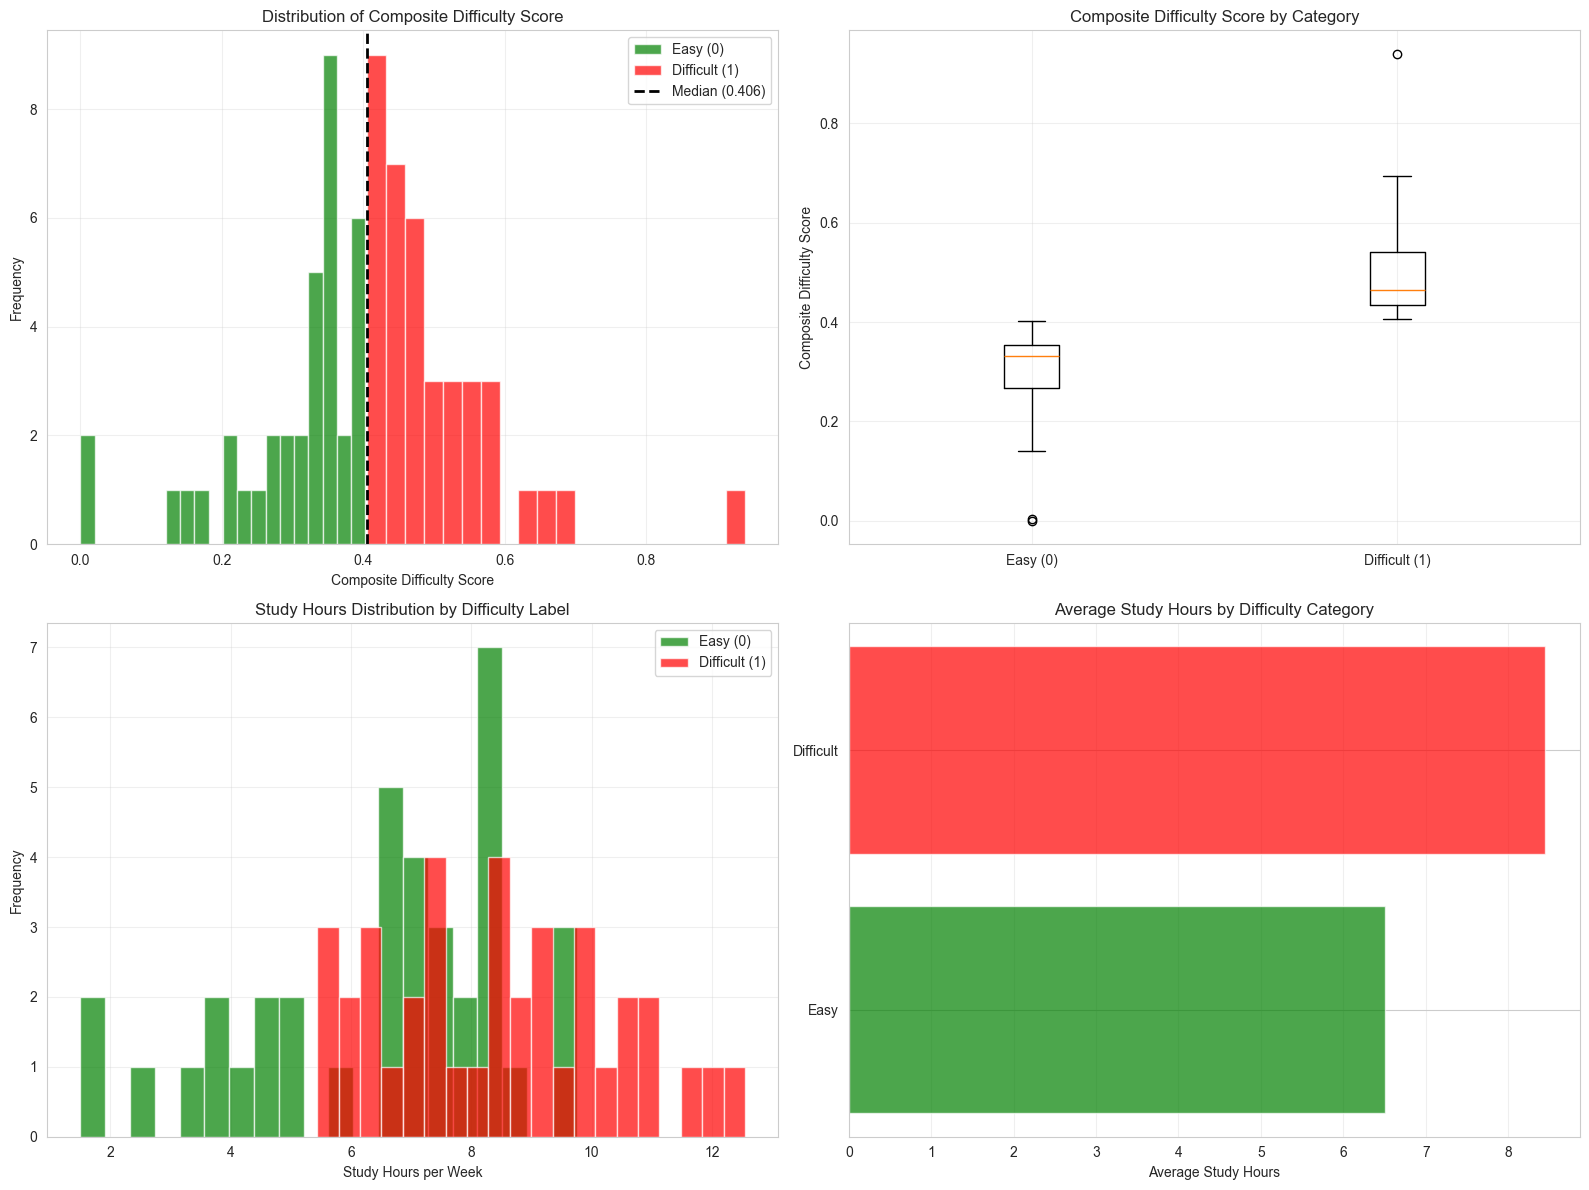


Manual difficulty labels created successfully based on composite SET features!
Features used: study_hours, learning_avg, structure_avg, environment_avg


In [37]:
# Step 4: Manually define difficulty based on multiple SET features
print("="*80)
print("MANUAL DIFFICULTY DEFINITION (Based on Multiple SET Features)")
print("="*80)
print("\nUsing composite difficulty score from:")
print("  - study_hours: Higher hours = more difficult")
print("  - learning_avg: Lower rating = more difficult")
print("  - structure_avg: Lower rating = more difficult")
print("  - environment_avg: Lower rating = more difficult")

# Filter to rows with all required features
required_features = ['study_hours', 'learning_avg', 'structure_avg', 'environment_avg']
df_with_features = merged_df[merged_df[required_features].notna().all(axis=1)].copy()
print(f"\nCourses with all required SET features: {len(df_with_features)}")

if len(df_with_features) == 0:
    print("⚠️  WARNING: No courses have all required features. Using available features...")
    # Use courses with at least study_hours
    df_with_features = merged_df[merged_df['study_hours'].notna()].copy()
    print(f"Courses with study_hours: {len(df_with_features)}")

# Create composite difficulty score
# Normalize each feature to [0, 1] range, then combine
print("\nCreating composite difficulty score...")

# Initialize difficulty components
difficulty_components = {}

# 1. Study hours: Higher = more difficult (normalize to [0,1])
if 'study_hours' in df_with_features.columns and df_with_features['study_hours'].notna().sum() > 0:
    hours_min = df_with_features['study_hours'].min()
    hours_max = df_with_features['study_hours'].max()
    if hours_max > hours_min:
        difficulty_components['study_hours'] = (df_with_features['study_hours'] - hours_min) / (hours_max - hours_min)
    else:
        difficulty_components['study_hours'] = pd.Series(0.5, index=df_with_features.index)
    print(f"  ✓ study_hours: range [{hours_min:.2f}, {hours_max:.2f}] hours")

# 2. Learning average: Lower = more difficult (invert and normalize)
if 'learning_avg' in df_with_features.columns and df_with_features['learning_avg'].notna().sum() > 0:
    learning_min = df_with_features['learning_avg'].min()
    learning_max = df_with_features['learning_avg'].max()
    if learning_max > learning_min:
        # Invert: lower learning_avg -> higher difficulty score
        difficulty_components['learning_avg'] = 1 - ((df_with_features['learning_avg'] - learning_min) / (learning_max - learning_min))
    else:
        difficulty_components['learning_avg'] = pd.Series(0.5, index=df_with_features.index)
    print(f"  ✓ learning_avg: range [{learning_min:.2f}, {learning_max:.2f}] (inverted)")

# 3. Structure average: Lower = more difficult (invert and normalize)
if 'structure_avg' in df_with_features.columns and df_with_features['structure_avg'].notna().sum() > 0:
    structure_min = df_with_features['structure_avg'].min()
    structure_max = df_with_features['structure_avg'].max()
    if structure_max > structure_min:
        # Invert: lower structure_avg -> higher difficulty score
        difficulty_components['structure_avg'] = 1 - ((df_with_features['structure_avg'] - structure_min) / (structure_max - structure_min))
    else:
        difficulty_components['structure_avg'] = pd.Series(0.5, index=df_with_features.index)
    print(f"  ✓ structure_avg: range [{structure_min:.2f}, {structure_max:.2f}] (inverted)")

# 4. Environment average: Lower = more difficult (invert and normalize)
if 'environment_avg' in df_with_features.columns and df_with_features['environment_avg'].notna().sum() > 0:
    env_min = df_with_features['environment_avg'].min()
    env_max = df_with_features['environment_avg'].max()
    if env_max > env_min:
        # Invert: lower environment_avg -> higher difficulty score
        difficulty_components['environment_avg'] = 1 - ((df_with_features['environment_avg'] - env_min) / (env_max - env_min))
    else:
        difficulty_components['environment_avg'] = pd.Series(0.5, index=df_with_features.index)
    print(f"  ✓ environment_avg: range [{env_min:.2f}, {env_max:.2f}] (inverted)")

# Combine all components into composite difficulty score (equal weights)
if len(difficulty_components) > 0:
    # Average all available components
    composite_scores = pd.DataFrame(difficulty_components).mean(axis=1)
    df_with_features['difficulty_score'] = composite_scores
    
    print(f"\nComposite difficulty score created using {len(difficulty_components)} features")
    print(f"  Score range: [{composite_scores.min():.4f}, {composite_scores.max():.4f}]")
    print(f"  Mean score: {composite_scores.mean():.4f}")
    print(f"  Median score: {composite_scores.median():.4f}")
    
    # Calculate median of composite score
    median_score = composite_scores.median()
    print(f"\nMedian composite difficulty score: {median_score:.4f}")
    
    # Define difficulty labels based on median split of composite score
    # Difficult = 1 (composite score >= median)
    # Easy = 0 (composite score < median)
    df_with_features['difficulty_manual'] = (df_with_features['difficulty_score'] >= median_score).astype(int)
else:
    print("⚠️  ERROR: No difficulty components could be created!")
    df_with_features['difficulty_score'] = 0.5
    df_with_features['difficulty_manual'] = 0

print(f"\nDifficulty distribution:")
print(df_with_features['difficulty_manual'].value_counts().sort_index())
print(f"\n  Easy (0):   {len(df_with_features[df_with_features['difficulty_manual']==0])} courses ({len(df_with_features[df_with_features['difficulty_manual']==0])/len(df_with_features)*100:.1f}%)")
print(f"  Difficult (1): {len(df_with_features[df_with_features['difficulty_manual']==1])} courses ({len(df_with_features[df_with_features['difficulty_manual']==1])/len(df_with_features)*100:.1f}%)")

# Show statistics by difficulty category
print("\n" + "="*80)
print("STATISTICS BY MANUAL DIFFICULTY LABEL")
print("="*80)

# Build aggregation dictionary with available features
agg_dict = {
    'difficulty_score': ['mean', 'std', 'min', 'max'],
    'course_number': ['mean', 'std', 'min', 'max']
}

# Add features if they exist
if 'study_hours' in df_with_features.columns:
    agg_dict['study_hours'] = ['mean', 'std', 'min', 'max']
if 'avg_grade' in df_with_features.columns:
    agg_dict['avg_grade'] = ['mean', 'std']
if 'learning_avg' in df_with_features.columns:
    agg_dict['learning_avg'] = ['mean', 'std']
if 'structure_avg' in df_with_features.columns:
    agg_dict['structure_avg'] = ['mean', 'std']
if 'environment_avg' in df_with_features.columns:
    agg_dict['environment_avg'] = ['mean', 'std']

difficulty_stats = df_with_features.groupby('difficulty_manual').agg(agg_dict).round(4)
print(difficulty_stats)

# Visualize the distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram of composite difficulty score by difficulty label
if 'difficulty_score' in df_with_features.columns:
    axes[0, 0].hist(df_with_features[df_with_features['difficulty_manual']==0]['difficulty_score'], 
                    bins=20, alpha=0.7, label='Easy (0)', color='green')
    axes[0, 0].hist(df_with_features[df_with_features['difficulty_manual']==1]['difficulty_score'], 
                    bins=20, alpha=0.7, label='Difficult (1)', color='red')
    if 'difficulty_score' in df_with_features.columns:
        median_score = df_with_features['difficulty_score'].median()
        axes[0, 0].axvline(median_score, color='black', linestyle='--', linewidth=2, 
                          label=f'Median ({median_score:.3f})')
    axes[0, 0].set_xlabel('Composite Difficulty Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Composite Difficulty Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot comparing composite difficulty score
if 'difficulty_score' in df_with_features.columns:
    box_data = [
        df_with_features[df_with_features['difficulty_manual']==0]['difficulty_score'].values,
        df_with_features[df_with_features['difficulty_manual']==1]['difficulty_score'].values
    ]
    axes[0, 1].boxplot(box_data, labels=['Easy (0)', 'Difficult (1)'])
    axes[0, 1].set_ylabel('Composite Difficulty Score')
    axes[0, 1].set_title('Composite Difficulty Score by Category')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Study hours by difficulty (if available)
if 'study_hours' in df_with_features.columns:
    axes[1, 0].hist(df_with_features[df_with_features['difficulty_manual']==0]['study_hours'], 
                    bins=20, alpha=0.7, label='Easy (0)', color='green')
    axes[1, 0].hist(df_with_features[df_with_features['difficulty_manual']==1]['study_hours'], 
                    bins=20, alpha=0.7, label='Difficult (1)', color='red')
    axes[1, 0].set_xlabel('Study Hours per Week')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Study Hours Distribution by Difficulty Label')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 4. Component contributions visualization
if len(difficulty_components) > 0:
    component_names = list(difficulty_components.keys())
    easy_means = [df_with_features[df_with_features['difficulty_manual']==0][f'difficulty_score'].mean() 
                  if 'difficulty_score' in df_with_features.columns else 0.5]
    difficult_means = [df_with_features[df_with_features['difficulty_manual']==1][f'difficulty_score'].mean() 
                       if 'difficulty_score' in df_with_features.columns else 0.5]
    
    # Show average component values by difficulty
    if 'study_hours' in df_with_features.columns:
        easy_hours = df_with_features[df_with_features['difficulty_manual']==0]['study_hours'].mean()
        diff_hours = df_with_features[df_with_features['difficulty_manual']==1]['study_hours'].mean()
        axes[1, 1].barh(['Easy', 'Difficult'], [easy_hours, diff_hours], 
                       color=['green', 'red'], alpha=0.7)
        axes[1, 1].set_xlabel('Average Study Hours')
        axes[1, 1].set_title('Average Study Hours by Difficulty Category')
        axes[1, 1].grid(True, alpha=0.3, axis='x')
    else:
        axes[1, 1].text(0.5, 0.5, 'Study hours data\nnot available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Component Analysis')

plt.tight_layout()
plt.savefig('difficulty_manual_definition.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Manual difficulty labels created successfully based on composite SET features!")
print(f"Features used: {', '.join(difficulty_components.keys())}")
print("="*80)


In [38]:
df_with_features

,course_number,quarter,study_hours,avg_grade,learning_avg,structure_avg,environment_avg,difficulty_score,difficulty_manual
0,10,fa23,8.475000,3.26,4.407500,4.030000,4.492500,0.433607,1
1,10,fa24,7.422000,3.014,4.520000,4.332000,4.592000,0.343215,0
2,10,sp24,7.980000,2.9,4.436667,4.190000,4.526667,0.394187,0
3,10,sp25,7.115000,2.995,4.460000,4.260000,4.485000,0.371164,0
4,10,wi24,8.116667,2.943333,4.390000,4.043333,4.483333,0.427740,1
...,...,...,...,...,...,...,...,...,...
70,190,fa23,7.370000,3.87,4.950000,4.960000,4.970000,0.148928,0
71,190,fa24,7.080000,3.756,4.472000,4.382000,4.688000,0.318277,0
72,190,sp24,7.623333,3.84,4.283333,4.203333,4.370000,0.431451,1
73,190,sp25,4.975000,3.79,4.530000,4.375000,4.525000,0.293707,0


## Step 5: Prepare Features for Logistic Regression

We'll select features that are:
1. **Available** (not too many missing values)
2. **Relevant** (theoretically related to course difficulty)
3. **Non-redundant** (avoid highly correlated features)

**Selected Features (ALL from SET data only):**
- **Learning Average** (SET): Quality of learning experience
- **Structure Average** (SET): Course organization quality
- **Environment Average** (SET): Classroom environment quality
- **Average Grade** (SET): Actual student performance (grades received)

**Note:** 
- The target variable (`difficulty_manual`) is defined using a composite score from:
  - `study_hours` (higher = more difficult)
  - `learning_avg` (lower = more difficult, inverted)
  - `structure_avg` (lower = more difficult, inverted)
  - `environment_avg` (lower = more difficult, inverted)
- We include `learning_avg`, `structure_avg`, and `environment_avg` as features since the model should learn how these individual components relate to the composite difficulty score
- We include `avg_grade` as a feature to capture actual student performance
- We exclude `study_hours` from features to avoid direct circularity, though it's part of the composite target
- We exclude `course_number` as it's not a meaningful predictor of difficulty (course number doesn't inherently indicate difficulty)
- No WebReg features are used in this analysis


In [39]:
# Step 5: Prepare features for logistic regression
print("="*80)
print("FEATURE PREPARATION FOR LOGISTIC REGRESSION")
print("="*80)

# Select features for modeling (ALL from SET data only)
# NOTE: We exclude 'study_hours' since it's used to define the target!
# NOTE: We exclude 'course_number' as it's not a meaningful predictor of difficulty
feature_columns = [
    'learning_avg',          # Learning quality (SET)
    'structure_avg',         # Course structure (SET)
    'environment_avg',       # Environment quality (SET)
    'avg_grade',             # Performance (SET) - actual student grades
]

# Create modeling dataset
model_df = df_with_features.copy()

# Debug: Check what columns are available
print(f"\nColumns in model_df: {list(model_df.columns)}")
print(f"Looking for features: {feature_columns}")
print(f"Features found in model_df: {[f for f in feature_columns if f in model_df.columns]}")
print(f"Features missing from model_df: {[f for f in feature_columns if f not in model_df.columns]}")

# Handle missing values - we'll use median imputation for numeric features
print("\nHandling missing values...")
for col in feature_columns:
    if col in model_df.columns:
        missing_count = model_df[col].isna().sum()
        if missing_count > 0:
            if model_df[col].dtype in ['int64', 'float64']:
                median_val = model_df[col].median()
                model_df[col] = model_df[col].fillna(median_val)
                print(f"  - {col}: {missing_count} missing values filled with median ({median_val:.2f})")
            else:
                mode_val = model_df[col].mode()[0] if len(model_df[col].mode()) > 0 else 0
                model_df[col] = model_df[col].fillna(mode_val)
                print(f"  - {col}: {missing_count} missing values filled with mode ({mode_val})")

# Select only features that exist in the dataframe
available_features = [f for f in feature_columns if f in model_df.columns]
print(f"\nAvailable features for modeling: {len(available_features)}")
print(f"Features: {available_features}")

# Create feature matrix X and target y
X = model_df[available_features].copy()
y = model_df['difficulty_manual'].copy()

# Remove any remaining NaN values
valid_idx = ~(X.isna().any(axis=1) | y.isna())
X = X[valid_idx]
y = y[valid_idx]

print(f"\nFinal dataset for modeling:")
print(f"  - Samples: {len(X)}")
print(f"  - Features: {len(X.columns)}")
print(f"  - Target distribution:")
print(f"    Easy (0):   {sum(y==0)} ({sum(y==0)/len(y)*100:.1f}%)")
print(f"    Difficult (1): {sum(y==1)} ({sum(y==1)/len(y)*100:.1f}%)")

# Check for class imbalance
if abs(sum(y==0) - sum(y==1)) / len(y) > 0.2:
    print("\n⚠️  WARNING: Class imbalance detected. Consider using class_weight='balanced' in logistic regression.")

# Display feature statistics
print("\n" + "="*80)
print("FEATURE STATISTICS")
print("="*80)
print(X.describe())


FEATURE PREPARATION FOR LOGISTIC REGRESSION

Columns in model_df: ['course_number', 'quarter', 'study_hours', 'avg_grade', 'learning_avg', 'structure_avg', 'environment_avg', 'difficulty_score', 'difficulty_manual']
Looking for features: ['learning_avg', 'structure_avg', 'environment_avg', 'avg_grade']
Features found in model_df: ['learning_avg', 'structure_avg', 'environment_avg', 'avg_grade']
Features missing from model_df: []

Handling missing values...
  - avg_grade: 8 missing values filled with mode (3.39)

Available features for modeling: 4
Features: ['learning_avg', 'structure_avg', 'environment_avg', 'avg_grade']

Final dataset for modeling:
  - Samples: 75
  - Features: 4
  - Target distribution:
    Easy (0):   37 (49.3%)
    Difficult (1): 38 (50.7%)

FEATURE STATISTICS
       learning_avg  structure_avg  environment_avg  avg_grade
count     75.000000      75.000000        75.000000  75.000000
mean       4.349438       4.217276         4.464078   3.398644
std        0.334567

## Step 6: Train-Test Split and Feature Scaling

Before training the logistic regression model, we need to:
1. Split data into training and testing sets (80/20 split)
2. Scale features (important for logistic regression with regularization)
3. Handle class imbalance if present


In [40]:
# Step 6: Train-test split and scaling
print("="*80)
print("TRAIN-TEST SPLIT AND FEATURE SCALING")
print("="*80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split:")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining set class distribution:")
print(f"  Easy (0):   {sum(y_train==0)} ({sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"  Difficult (1): {sum(y_train==1)} ({sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"\nTest set class distribution:")
print(f"  Easy (0):   {sum(y_test==0)} ({sum(y_test==0)/len(y_test)*100:.1f}%)")
print(f"  Difficult (1): {sum(y_test==1)} ({sum(y_test==1)/len(y_test)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n✓ Features scaled using StandardScaler (mean=0, std=1)")
print("✓ Ready for logistic regression training")


TRAIN-TEST SPLIT AND FEATURE SCALING

Data split:
  Training set: 60 samples (80.0%)
  Test set: 15 samples (20.0%)

Training set class distribution:
  Easy (0):   30 (50.0%)
  Difficult (1): 30 (50.0%)

Test set class distribution:
  Easy (0):   7 (46.7%)
  Difficult (1): 8 (53.3%)

✓ Features scaled using StandardScaler (mean=0, std=1)
✓ Ready for logistic regression training


## Step 7: Train Logistic Regression Model

We'll train a logistic regression model with:
- **L2 regularization** (Ridge) to prevent overfitting
- **Class balancing** to handle any class imbalance
- **Maximum iterations** to ensure convergence

The model will predict the probability that a course is "difficult" (1) based on the features.


In [41]:
# Step 7: Train logistic regression model
print("="*80)
print("TRAINING LOGISTIC REGRESSION MODEL")
print("="*80)

# Initialize logistic regression with balanced class weights
logreg = LogisticRegression(
    penalty='l2',                    # L2 regularization (Ridge)
    C=1.0,                          # Inverse regularization strength
    class_weight='balanced',        # Handle class imbalance
    max_iter=1000,                  # Maximum iterations
    random_state=42,
    solver='lbfgs'                  # Good default solver
)

# Train the model
print("\nTraining model...")
logreg.fit(X_train_scaled_df, y_train)

print("✓ Model trained successfully!")

# Get predictions
y_train_pred = logreg.predict(X_train_scaled_df)
y_test_pred = logreg.predict(X_test_scaled_df)

# Get prediction probabilities
y_train_proba = logreg.predict_proba(X_train_scaled_df)[:, 1]  # Probability of class 1 (difficult)
y_test_proba = logreg.predict_proba(X_test_scaled_df)[:, 1]

print(f"\nModel coefficients (log-odds):")
print(f"  Intercept: {logreg.intercept_[0]:.4f}")
print(f"\nFeature coefficients:")
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg.coef_[0],
    'Abs_Coefficient': np.abs(logreg.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)
print(coef_df.to_string(index=False))

# Add logistic regression predictions to the dataframe
model_df.loc[X_train.index, 'difficulty_logreg'] = y_train_pred
model_df.loc[X_test.index, 'difficulty_logreg'] = y_test_pred
model_df.loc[X_train.index, 'difficulty_logreg_proba'] = y_train_proba
model_df.loc[X_test.index, 'difficulty_logreg_proba'] = y_test_proba

print("\n✓ Predictions added to dataset")


TRAINING LOGISTIC REGRESSION MODEL

Training model...
✓ Model trained successfully!

Model coefficients (log-odds):
  Intercept: 0.2990

Feature coefficients:
        Feature  Coefficient  Abs_Coefficient
  structure_avg    -1.396351         1.396351
environment_avg    -1.152314         1.152314
   learning_avg    -1.040608         1.040608
      avg_grade     0.037552         0.037552

✓ Predictions added to dataset


## Step 8: Model Performance Evaluation

We'll evaluate the model using multiple metrics:
- **Accuracy**: Overall correctness
- **Precision**: Of predicted difficult courses, how many are actually difficult?
- **Recall**: Of actually difficult courses, how many did we catch?
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under ROC curve (overall discriminative ability)
- **Confusion Matrix**: Detailed breakdown of predictions


MODEL PERFORMANCE EVALUATION

PERFORMANCE METRICS
   Metric    Train     Test
 Accuracy 0.883333 0.733333
Precision 0.925926 0.750000
   Recall 0.833333 0.750000
 F1-Score 0.877193 0.750000
  ROC-AUC 0.951111 0.892857

CONFUSION MATRICES

Training Set:
[[28  2]
 [ 5 25]]

  True Negatives (Easy→Easy): 28
  False Positives (Easy→Difficult): 2
  False Negatives (Difficult→Easy): 5
  True Positives (Difficult→Difficult): 25

Test Set:
[[5 2]
 [2 6]]

  True Negatives (Easy→Easy): 5
  False Positives (Easy→Difficult): 2
  False Negatives (Difficult→Easy): 2
  True Positives (Difficult→Difficult): 6

DETAILED CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

        Easy       0.71      0.71      0.71         7
   Difficult       0.75      0.75      0.75         8

    accuracy                           0.73        15
   macro avg       0.73      0.73      0.73        15
weighted avg       0.73      0.73      0.73        15



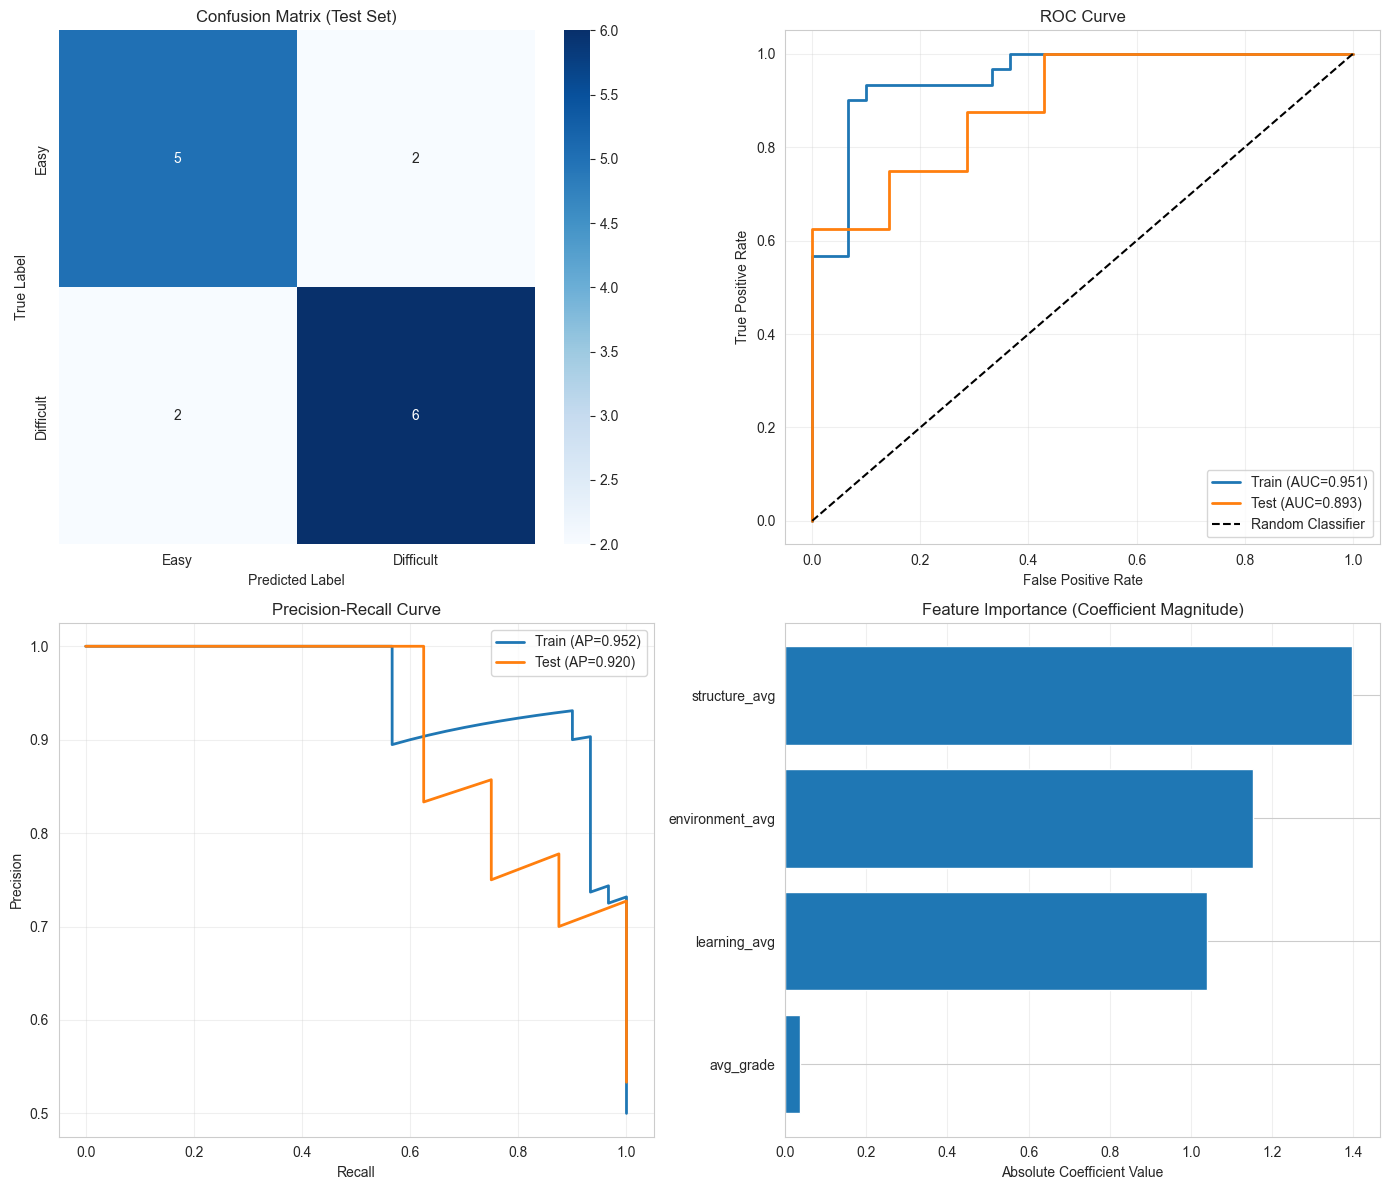


✓ Model evaluation complete!


In [42]:
# Step 8: Evaluate model performance
print("="*80)
print("MODEL PERFORMANCE EVALUATION")
print("="*80)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Create performance table
performance_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1, train_auc],
    'Test': [test_accuracy, test_precision, test_recall, test_f1, test_auc]
})

print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)
print(performance_table.to_string(index=False))

# Confusion matrices
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)
print("\nTraining Set:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
print(f"\n  True Negatives (Easy→Easy): {cm_train[0,0]}")
print(f"  False Positives (Easy→Difficult): {cm_train[0,1]}")
print(f"  False Negatives (Difficult→Easy): {cm_train[1,0]}")
print(f"  True Positives (Difficult→Difficult): {cm_train[1,1]}")

print("\nTest Set:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
print(f"\n  True Negatives (Easy→Easy): {cm_test[0,0]}")
print(f"  False Positives (Easy→Difficult): {cm_test[0,1]}")
print(f"  False Negatives (Difficult→Easy): {cm_test[1,0]}")
print(f"  True Positives (Difficult→Difficult): {cm_test[1,1]}")

# Classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['Easy', 'Difficult']))

# Visualize performance
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion matrix heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Easy', 'Difficult'], yticklabels=['Easy', 'Difficult'])
axes[0,0].set_title('Confusion Matrix (Test Set)')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
axes[0,1].plot(fpr_train, tpr_train, label=f'Train (AUC={train_auc:.3f})', linewidth=2)
axes[0,1].plot(fpr_test, tpr_test, label=f'Test (AUC={test_auc:.3f})', linewidth=2)
axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
axes[1,0].plot(recall_train, precision_train, label=f'Train (AP={average_precision_score(y_train, y_train_proba):.3f})', linewidth=2)
axes[1,0].plot(recall_test, precision_test, label=f'Test (AP={average_precision_score(y_test, y_test_proba):.3f})', linewidth=2)
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Feature importance (coefficient magnitude)
coef_df_sorted = coef_df.sort_values('Abs_Coefficient', ascending=True)
axes[1,1].barh(coef_df_sorted['Feature'], coef_df_sorted['Abs_Coefficient'])
axes[1,1].set_xlabel('Absolute Coefficient Value')
axes[1,1].set_title('Feature Importance (Coefficient Magnitude)')
axes[1,1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('logistic_regression_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✓ Model evaluation complete!")
print("="*80)


## Step 9: Feature Contribution Analysis

We'll analyze feature contributions using two complementary methods:

1. **Coefficient Analysis**: Direct interpretation of logistic regression coefficients (log-odds)
2. **Permutation Importance**: Model-agnostic measure of how much each feature contributes to predictions

This dual approach provides both interpretability (coefficients) and robustness (permutation importance).


FEATURE CONTRIBUTION ANALYSIS

METHOD 1: COEFFICIENT ANALYSIS

Coefficients represent log-odds changes:
  - Positive coefficient: Increases probability of 'Difficult'
  - Negative coefficient: Decreases probability of 'Difficult'
  - Larger absolute value: Stronger effect

Feature Coefficients and Odds Ratios:
        Feature  Coefficient  Abs_Coefficient  Odds_Ratio          Odds_Ratio_Interpretation
  structure_avg    -1.396351         1.396351    0.247499 0.247x less likely to be difficult
environment_avg    -1.152314         1.152314    0.315905 0.316x less likely to be difficult
   learning_avg    -1.040608         1.040608    0.353240 0.353x less likely to be difficult
      avg_grade     0.037552         0.037552    1.038266 1.038x more likely to be difficult

METHOD 2: PERMUTATION IMPORTANCE

Calculating permutation importance (this may take a moment)...
This measures how much model performance drops when each feature is randomly shuffled.

Permutation Importance Results:
(High

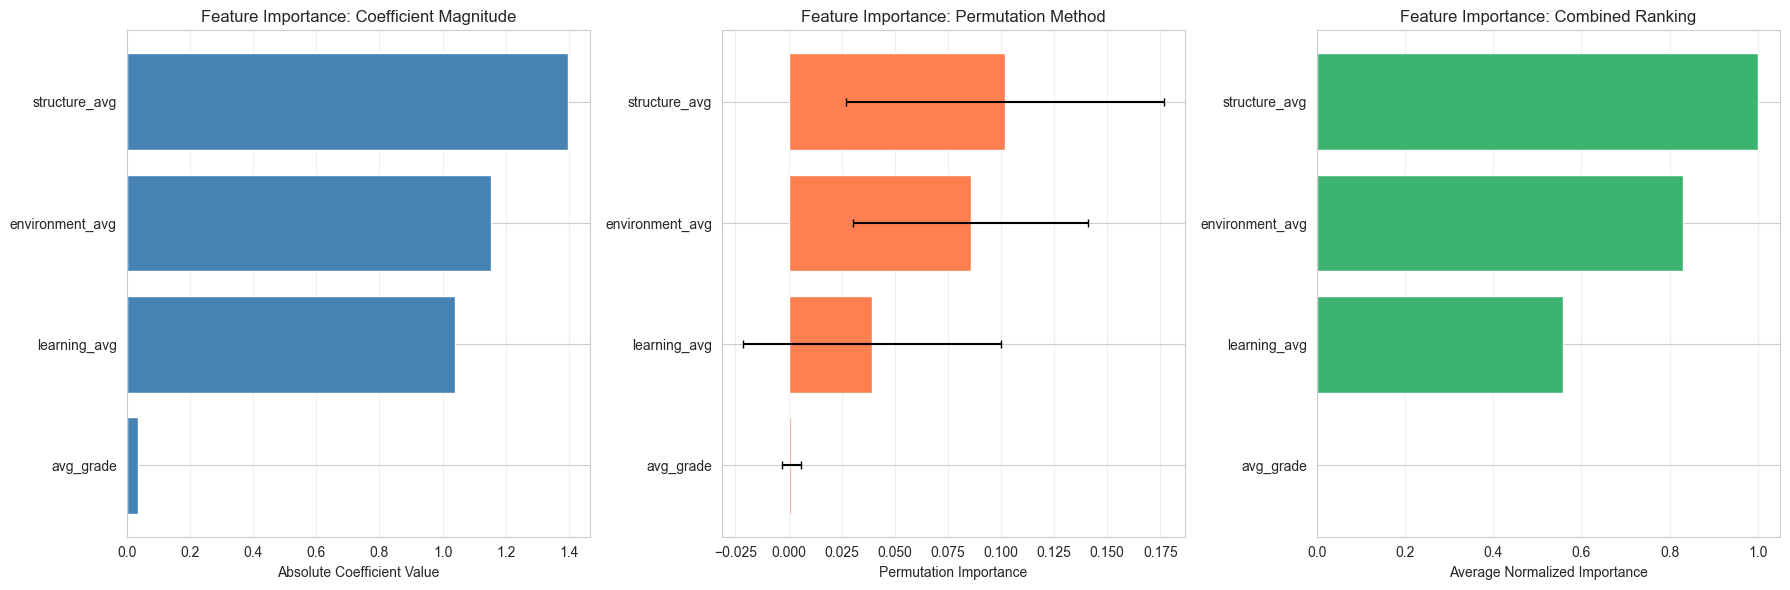


✓ Feature contribution analysis complete!


In [43]:
# Step 9: Feature contribution analysis
print("="*80)
print("FEATURE CONTRIBUTION ANALYSIS")
print("="*80)

# Method 1: Coefficient Analysis
print("\n" + "="*60)
print("METHOD 1: COEFFICIENT ANALYSIS")
print("="*60)
print("\nCoefficients represent log-odds changes:")
print("  - Positive coefficient: Increases probability of 'Difficult'")
print("  - Negative coefficient: Decreases probability of 'Difficult'")
print("  - Larger absolute value: Stronger effect")

# Calculate odds ratios for easier interpretation
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])
coef_df['Odds_Ratio_Interpretation'] = coef_df['Odds_Ratio'].apply(
    lambda x: f"{x:.3f}x {'more' if x > 1 else 'less'} likely to be difficult"
)

print("\nFeature Coefficients and Odds Ratios:")
print(coef_df[['Feature', 'Coefficient', 'Abs_Coefficient', 'Odds_Ratio', 'Odds_Ratio_Interpretation']].to_string(index=False))

# Method 2: Permutation Importance
print("\n" + "="*60)
print("METHOD 2: PERMUTATION IMPORTANCE")
print("="*60)
print("\nCalculating permutation importance (this may take a moment)...")
print("This measures how much model performance drops when each feature is randomly shuffled.")

# Calculate permutation importance
perm_importance = permutation_importance(
    logreg, X_test_scaled_df, y_test,
    n_repeats=30, random_state=42, scoring='roc_auc'
)

perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("\nPermutation Importance Results:")
print("(Higher values = more important for predictions)")
print(perm_df.to_string(index=False))

# Combine both methods for comprehensive view
print("\n" + "="*60)
print("COMBINED FEATURE IMPORTANCE RANKING")
print("="*60)

# Normalize both metrics to 0-1 scale for comparison
coef_df_norm = coef_df.copy()
coef_df_norm['Coefficient_Normalized'] = (coef_df_norm['Abs_Coefficient'] - coef_df_norm['Abs_Coefficient'].min()) / \
                                         (coef_df_norm['Abs_Coefficient'].max() - coef_df_norm['Abs_Coefficient'].min())

perm_df_norm = perm_df.copy()
perm_df_norm['Importance_Normalized'] = (perm_df_norm['Importance_Mean'] - perm_df_norm['Importance_Mean'].min()) / \
                                        (perm_df_norm['Importance_Mean'].max() - perm_df_norm['Importance_Mean'].min())

# Merge
combined_importance = coef_df_norm[['Feature', 'Coefficient_Normalized']].merge(
    perm_df_norm[['Feature', 'Importance_Normalized']], on='Feature'
)
combined_importance['Average_Importance'] = (
    combined_importance['Coefficient_Normalized'] + combined_importance['Importance_Normalized']
) / 2
combined_importance = combined_importance.sort_values('Average_Importance', ascending=False)

print("\nRanked by average of normalized coefficient magnitude and permutation importance:")
print(combined_importance[['Feature', 'Coefficient_Normalized', 'Importance_Normalized', 'Average_Importance']].to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Coefficient magnitude
coef_df_sorted = coef_df.sort_values('Abs_Coefficient', ascending=True)
axes[0].barh(coef_df_sorted['Feature'], coef_df_sorted['Abs_Coefficient'], color='steelblue')
axes[0].set_xlabel('Absolute Coefficient Value')
axes[0].set_title('Feature Importance: Coefficient Magnitude')
axes[0].grid(True, alpha=0.3, axis='x')

# Permutation importance
perm_df_sorted = perm_df.sort_values('Importance_Mean', ascending=True)
axes[1].barh(perm_df_sorted['Feature'], perm_df_sorted['Importance_Mean'], 
             xerr=perm_df_sorted['Importance_Std'], color='coral', capsize=3)
axes[1].set_xlabel('Permutation Importance')
axes[1].set_title('Feature Importance: Permutation Method')
axes[1].grid(True, alpha=0.3, axis='x')

# Combined ranking
combined_sorted = combined_importance.sort_values('Average_Importance', ascending=True)
axes[2].barh(combined_sorted['Feature'], combined_sorted['Average_Importance'], color='mediumseagreen')
axes[2].set_xlabel('Average Normalized Importance')
axes[2].set_title('Feature Importance: Combined Ranking')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✓ Feature contribution analysis complete!")
print("="*80)


## Step 10: Summary and Final Dataset

**Final Dataset Structure:**
- All SET feature columns (learning_avg, structure_avg, environment_avg, avg_grade, study_hours, course_number, quarter)
- `difficulty_manual`: Manually assigned easy/difficult labels (ground truth based on SET study hours median split)
- `difficulty_logreg`: Logistic regression predictions (0 = Easy, 1 = Difficult)
- `difficulty_logreg_proba`: Probability of being difficult (0-1)

**Key Findings:**
1. Manual difficulty definition based on SET study hours median split
2. Logistic regression model performance metrics
3. Feature contributions ranked by importance (all from SET data)
4. Model can predict difficulty using SET evaluation features (learning, structure, environment averages, grades)

**Note:** This analysis uses ONLY SET data.


In [ ]:
# Step 10: Final summary and dataset export
print("="*80)
print("FINAL SUMMARY")
print("="*80)

print("\nDataset Summary:")
print(f"  Total samples: {len(model_df)}")
print(f"  Features used: {len(available_features)}")
print(f"  Manual labels created: {model_df['difficulty_manual'].notna().sum()}")
print(f"  Logistic regression predictions: {model_df['difficulty_logreg'].notna().sum()}")

print("\n" + "="*60)
print("MANUAL vs LOGISTIC REGRESSION LABELS COMPARISON")
print("="*60)
comparison = pd.crosstab(model_df['difficulty_manual'], model_df['difficulty_logreg'], 
                        margins=True, margins_name="Total")
comparison.index = ['Easy (Manual)', 'Difficult (Manual)', 'Total']
comparison.columns = ['Easy (LR)', 'Difficult (LR)', 'Total']
print(comparison)

# Calculate agreement
agreement = (model_df['difficulty_manual'] == model_df['difficulty_logreg']).sum()
agreement_pct = agreement / len(model_df[model_df['difficulty_logreg'].notna()]) * 100
print(f"\nAgreement between manual labels and logistic regression: {agreement}/{len(model_df[model_df['difficulty_logreg'].notna()])} ({agreement_pct:.1f}%)")

# Save final dataset
output_file = 'merged_data_with_difficulty_labels.csv'
model_df.to_csv(output_file, index=False)
print(f"\n✓ Final dataset saved to: {output_file}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nNext steps for report integration:")
print("1. Document the manual difficulty definition rationale (composite SET features)")
print("2. Report model performance metrics (accuracy, precision, recall, F1, ROC-AUC)")
print("3. Discuss feature contributions and their interpretations (all SET features)")
print("4. Compare manual labels vs. logistic regression predictions")
print("5. Discuss implications for understanding course difficulty factors")
print("\nNote: This analysis uses ONLY SET data.")


FINAL SUMMARY

Dataset Summary:
  Total samples: 75
  Features used: 4
  Manual labels created: 75
  Logistic regression predictions: 75

MANUAL vs LOGISTIC REGRESSION LABELS COMPARISON
                    Easy (LR)  Difficult (LR)  Total
Easy (Manual)              33               4     37
Difficult (Manual)          7              31     38
Total                      40              35     75

Agreement between manual labels and logistic regression: 64/75 (85.3%)

✓ Final dataset saved to: merged_data_with_difficulty_labels.csv

PART 1 ANALYSIS COMPLETE!

Next steps for report integration:
1. Document the manual difficulty definition rationale (SET study hours median split)
2. Report model performance metrics (accuracy, precision, recall, F1, ROC-AUC)
3. Discuss feature contributions and their interpretations (all SET features)
4. Compare manual labels vs. logistic regression predictions
5. Discuss implications for understanding course difficulty factors

Note: Part 1 uses ONLY SET d

In [ ]:
# Import additional libraries for statistical tests
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr, spearmanr
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')


## Step 1: Data Cleaning and Preparation


In [ ]:
# Load and clean CAPES data
all_capes = pd.read_csv('datasets/all_capes.csv')

# Extract course number from course_title (e.g., "dsc100" -> 100)
def extract_course_number(course_title):
    """Extract numeric course number from course title"""
    if pd.isna(course_title):
        return None
    import re
    match = re.search(r'dsc(\d+)', str(course_title).lower())
    if match:
        return int(match.group(1))
    return None

# Clean CAPES data
all_capes['course_number'] = all_capes['course_title'].apply(extract_course_number)
all_capes = all_capes[all_capes['course_number'].notna()]  # Keep only DSC courses

# Extract numeric grade from Avg Grade Received
all_capes['Avg_Grade_Received'] = (
    all_capes['Avg Grade Received']
    .str.extract(r'(\d+\.\d+|\d+)')
    .astype(float)
)

# Clean column names
all_capes.columns = all_capes.columns.str.replace('*', '', regex=False)
all_capes.columns = all_capes.columns.str.replace(' ', '_')
all_capes.columns = all_capes.columns.str.replace('/', '_')

# Standardize term format (e.g., "FA24" -> "fa24", "WI25" -> "wi25")
def standardize_term(term):
    """Convert term format to match webreg format"""
    if pd.isna(term):
        return None
    term_str = str(term).upper()
    # Map common formats
    term_map = {
        'FA24': 'fa24', 'WI25': 'wi25', 'SP25': 'sp25',
        'FALL 2024': 'fa24', 'WINTER 2025': 'wi25', 'SPRING 2025': 'sp25',
        'FA 2024': 'fa24', 'WI 2025': 'wi25', 'SP 2025': 'sp25'
    }
    if term_str in term_map:
        return term_map[term_str]
    # Try to extract pattern
    import re
    match = re.search(r'(FA|WI|SP|FALL|WINTER|SPRING)\s*(\d{2,4})', term_str)
    if match:
        season = match.group(1)[:2].upper()
        year = match.group(2)[-2:]  # Last 2 digits
        if season.startswith('FA'):
            return f'fa{year}'
        elif season.startswith('WI'):
            return f'wi{year}'
        elif season.startswith('SP'):
            return f'sp{year}'
    return None

all_capes['quarter'] = all_capes['Term'].apply(standardize_term)
print(f"CAPES data: {len(all_capes)} rows, {all_capes['course_number'].nunique()} unique courses")
print(f"Terms in CAPES: {sorted(all_capes['quarter'].dropna().unique())}")


In [ ]:
# Clean SET data (already loaded in cell 2)
# Extract course number from course_title
dsc_sets['course_number'] = dsc_sets['course_title'].apply(extract_course_number)
dsc_sets = dsc_sets[dsc_sets['course_number'].notna()]

# Standardize term format for SET data
dsc_sets['quarter'] = dsc_sets['Term'].apply(standardize_term)

# Filter to only FA24, WI25, SP25 quarters (matching webreg data)
valid_quarters = ['fa24', 'wi25', 'sp25']
dsc_sets = dsc_sets[dsc_sets['quarter'].isin(valid_quarters)]

print(f"SET data: {len(dsc_sets)} rows, {dsc_sets['course_number'].nunique()} unique courses")
print(f"Terms in SET: {sorted(dsc_sets['quarter'].dropna().unique())}")
print(f"\nSET columns: {dsc_sets.columns.tolist()}")


In [ ]:
# Aggregate historical CAPES data by course (for courses not in current quarters)
# Calculate historical averages for difficulty metrics
capes_historical = all_capes.groupby('course_number').agg({
    'Avg_Hours_Worked': 'mean',
    'Avg_Grade_Received': 'mean',
    'Learning_Average': 'mean',
    'Structure_Average': 'mean',
    'Environment_Average': 'mean'
}).reset_index()
capes_historical.columns = ['course_number', 'hist_avg_hours', 'hist_avg_grade', 
                           'hist_learning_avg', 'hist_structure_avg', 'hist_environment_avg']

# For current quarter data, use SET if available, otherwise use CAPES
# First, aggregate SET data by course and quarter
sets_agg = dsc_sets.groupby(['course_number', 'quarter']).agg({
    'Avg_Hours_Worked': 'mean',
    'Avg_Grade_Received': 'mean',
    'Learning_Average': 'mean',
    'Structure_Average': 'mean',
    'Environment_Average': 'mean'
}).reset_index()
sets_agg.columns = ['course_number', 'quarter', 'avg_hours', 'avg_grade',
                    'learning_avg', 'structure_avg', 'environment_avg']

# Merge SET data with webreg
merged_data = webreg_data.merge(
    sets_agg,
    on=['course_number', 'quarter'],
    how='left'
)

# For courses without SET data, use historical CAPES averages
merged_data = merged_data.merge(
    capes_historical,
    on='course_number',
    how='left'
)

# Use SET data if available, otherwise use historical CAPES
merged_data['study_hours'] = merged_data['avg_hours'].fillna(merged_data['hist_avg_hours'])
merged_data['avg_grade'] = merged_data['avg_grade'].fillna(merged_data['hist_avg_grade'])
merged_data['learning_avg'] = merged_data['learning_avg'].fillna(merged_data['hist_learning_avg'])
merged_data['structure_avg'] = merged_data['structure_avg'].fillna(merged_data['hist_structure_avg'])
merged_data['environment_avg'] = merged_data['environment_avg'].fillna(merged_data['hist_environment_avg'])

print(f"Merged data: {len(merged_data)} rows")
print(f"Rows with SET data: {merged_data['avg_hours'].notna().sum()}")
print(f"Rows with historical CAPES data: {merged_data['hist_avg_hours'].notna().sum()}")
print(f"Rows with any evaluation data: {merged_data['study_hours'].notna().sum()}")
merged_data.head()


In [ ]:
# Create difficulty categories based on study hours, grade gaps, and composite difficulty score
# First, calculate grade gap (assuming expected grade is 3.5 for B+ average)
merged_data['expected_grade'] = 3.5  # Typical expected grade
merged_data['grade_gap'] = merged_data['expected_grade'] - merged_data['avg_grade']  # Positive = harder

# Create composite difficulty score (normalized)
# Higher study hours + larger grade gap = more difficult
from sklearn.preprocessing import StandardScaler

# Only calculate for rows with data
data_subset = merged_data[merged_data['study_hours'].notna() & merged_data['avg_grade'].notna()].copy()

if len(data_subset) > 0:
    scaler = StandardScaler()
    data_subset['hours_scaled'] = scaler.fit_transform(data_subset[['study_hours']])
    data_subset['gap_scaled'] = scaler.fit_transform(data_subset[['grade_gap']])
    data_subset['difficulty_score'] = (data_subset['hours_scaled'] + data_subset['gap_scaled']) / 2
    
    # Merge back
    merged_data = merged_data.merge(
        data_subset[['course_number', 'quarter', 'difficulty_score', 'grade_gap']],
        on=['course_number', 'quarter'],
        how='left',
        suffixes=('', '_new')
    )
    
    # Update difficulty_score and grade_gap
    merged_data['difficulty_score'] = merged_data['difficulty_score_new'].fillna(merged_data['difficulty_score'])
    merged_data['grade_gap'] = merged_data['grade_gap_new'].fillna(merged_data['grade_gap'])
    merged_data = merged_data.drop(columns=['difficulty_score_new', 'grade_gap_new'], errors='ignore')

# Create difficulty categories
def categorize_difficulty(row):
    """Categorize course difficulty based on multiple factors"""
    if pd.isna(row.get('difficulty_score', np.nan)):
        return 'Unknown'
    
    score = row['difficulty_score']
    hours = row.get('study_hours', np.nan)
    gap = row.get('grade_gap', np.nan)
    
    # Use percentiles if we have enough data
    if len(merged_data[merged_data['difficulty_score'].notna()]) > 5:
        p33 = merged_data['difficulty_score'].quantile(0.33)
        p67 = merged_data['difficulty_score'].quantile(0.67)
        
        if score <= p33:
            return 'Easy'
        elif score <= p67:
            return 'Moderate'
        else:
            return 'Difficult'
    else:
        # Fallback to simple thresholds
        if score < -0.5:
            return 'Easy'
        elif score < 0.5:
            return 'Moderate'
        else:
            return 'Difficult'

merged_data['difficulty_category'] = merged_data.apply(categorize_difficulty, axis=1)

print(f"Difficulty categories: {merged_data['difficulty_category'].value_counts()}")
print(f"\nFinal merged dataset: {len(merged_data)} rows")
print(f"Columns: {merged_data.columns.tolist()}")


## Step 2: Statistical Tests

We will perform 6 key statistical tests to explore the relationship between historical course difficulty/evaluations and current enrollment patterns:

1. **Independent Samples t-test**: Difficulty category vs. Utilization rate
2. **Pearson Correlation**: Study hours vs. Utilization rate  
3. **Spearman Correlation**: Learning Average vs. Enrollment
4. **One-way ANOVA**: Difficulty category vs. Utilization rate (3 groups)
5. **Two-way ANOVA**: Difficulty category × Division level interaction on Utilization rate
6. **Chi-square Test**: Difficulty category vs. Oversubscription status


### Test 1: Independent Samples t-test - Easy vs. Difficult Courses
**Purpose**: Test if courses categorized as "Easy" have significantly different utilization rates than "Difficult" courses.

**Null Hypothesis (H₀)**: Mean utilization rates are equal between Easy and Difficult courses.

**Alternative Hypothesis (H₁)**: Mean utilization rates differ between Easy and Difficult courses.


In [ ]:
# Test 1: t-test Easy vs Difficult
test1_data = merged_data[merged_data['difficulty_category'].isin(['Easy', 'Difficult'])]
easy_util = test1_data[test1_data['difficulty_category'] == 'Easy']['utilization_rate']
difficult_util = test1_data[test1_data['difficulty_category'] == 'Difficult']['utilization_rate']

t_stat1, p_value1 = ttest_ind(easy_util, difficult_util)

test1_results = pd.DataFrame({
    'Test': ['t-test: Easy vs Difficult'],
    'Group_1': ['Easy'],
    'Group_1_n': [len(easy_util)],
    'Group_1_Mean': [easy_util.mean()],
    'Group_2': ['Difficult'],
    'Group_2_n': [len(difficult_util)],
    'Group_2_Mean': [difficult_util.mean()],
    't_statistic': [t_stat1],
    'p_value': [p_value1],
    'Significant': ['Yes' if p_value1 < 0.05 else 'No']
})

print("Test 1 Results:")
print(test1_results.to_string(index=False))
print(f"\nInterpretation: {'Significant difference found' if p_value1 < 0.05 else 'No significant difference'} between Easy and Difficult courses.")


**Interpretation**: This test directly addresses our research question by comparing enrollment patterns between historically easy and difficult courses. A significant result (p < 0.05) would support the alternative hypothesis that course difficulty influences enrollment.


### Test 2: Pearson Correlation - Study Hours vs. Utilization Rate
**Purpose**: Test the linear relationship between historical study hours and current course utilization rates.

**Null Hypothesis (H₀)**: No linear correlation between study hours and utilization rate (ρ = 0).

**Alternative Hypothesis (H₁)**: Significant linear correlation exists (ρ ≠ 0).


In [ ]:
# Test 2: Pearson Correlation - Study Hours vs Utilization
test2_data = merged_data[merged_data['study_hours'].notna() & merged_data['utilization_rate'].notna()]
corr2, p_value2 = pearsonr(test2_data['study_hours'], test2_data['utilization_rate'])

test2_results = pd.DataFrame({
    'Test': ['Pearson Correlation'],
    'Variable_1': ['Study Hours'],
    'Variable_2': ['Utilization Rate'],
    'n': [len(test2_data)],
    'Correlation': [corr2],
    'p_value': [p_value2],
    'Significant': ['Yes' if p_value2 < 0.05 else 'No']
})

print("Test 2 Results:")
print(test2_results.to_string(index=False))
print(f"\nInterpretation: {'Significant correlation found' if p_value2 < 0.05 else 'No significant correlation'}.")
if p_value2 < 0.05:
    direction = "positive" if corr2 > 0 else "negative"
    print(f"Direction: {direction} correlation (r = {corr2:.4f})")


**Interpretation**: A negative correlation would suggest that courses with higher historical study hours (more difficult) have lower enrollment, supporting our hypothesis. A positive correlation would indicate the opposite pattern.


### Test 3: Spearman Correlation - Learning Average vs. Enrollment
**Purpose**: Test the monotonic relationship between historical learning quality ratings and current enrollment numbers (rank-based, more robust to outliers).

**Null Hypothesis (H₀)**: No monotonic correlation between learning average and enrollment (ρ = 0).

**Alternative Hypothesis (H₁)**: Significant monotonic correlation exists (ρ ≠ 0).


In [ ]:
# Test 3: Spearman Correlation - Learning Average vs Enrollment
test3_data = merged_data[merged_data['learning_avg'].notna() & merged_data['enrolled'].notna()]
corr3, p_value3 = spearmanr(test3_data['learning_avg'], test3_data['enrolled'])

test3_results = pd.DataFrame({
    'Test': ['Spearman Correlation'],
    'Variable_1': ['Learning Average'],
    'Variable_2': ['Enrollment'],
    'n': [len(test3_data)],
    'Correlation': [corr3],
    'p_value': [p_value3],
    'Significant': ['Yes' if p_value3 < 0.05 else 'No']
})

print("Test 3 Results:")
print(test3_results.to_string(index=False))
print(f"\nInterpretation: {'Significant correlation found' if p_value3 < 0.05 else 'No significant correlation'}.")
if p_value3 < 0.05:
    direction = "positive" if corr3 > 0 else "negative"
    print(f"Direction: {direction} correlation (ρ = {corr3:.4f})")


**Interpretation**: This tests whether courses with better historical learning quality ratings attract more students. A positive correlation supports the alternative hypothesis that higher-rated courses have higher enrollment.


### Test 4: One-way ANOVA - Difficulty Category vs. Utilization Rate
**Purpose**: Test if utilization rates differ significantly across all three difficulty categories (Easy, Moderate, Difficult).

**Null Hypothesis (H₀)**: All difficulty categories have equal mean utilization rates.

**Alternative Hypothesis (H₁)**: At least one difficulty category differs in mean utilization rate.


In [ ]:
# Test 4: One-way ANOVA - Difficulty Category
test4_data = merged_data[merged_data['difficulty_category'].isin(['Easy', 'Moderate', 'Difficult'])]
easy_group = test4_data[test4_data['difficulty_category'] == 'Easy']['utilization_rate']
moderate_group = test4_data[test4_data['difficulty_category'] == 'Moderate']['utilization_rate']
difficult_group = test4_data[test4_data['difficulty_category'] == 'Difficult']['utilization_rate']

f_stat4, p_value4 = f_oneway(easy_group, moderate_group, difficult_group)

test4_results = pd.DataFrame({
    'Test': ['One-way ANOVA'],
    'Factor': ['Difficulty Category'],
    'Groups': ['Easy, Moderate, Difficult'],
    'n_Easy': [len(easy_group)],
    'Mean_Easy': [easy_group.mean()],
    'n_Moderate': [len(moderate_group)],
    'Mean_Moderate': [moderate_group.mean()],
    'n_Difficult': [len(difficult_group)],
    'Mean_Difficult': [difficult_group.mean()],
    'F_statistic': [f_stat4],
    'p_value': [p_value4],
    'Significant': ['Yes' if p_value4 < 0.05 else 'No']
})

print("Test 4 Results:")
print(test4_results.to_string(index=False))
print(f"\nInterpretation: {'Significant differences found' if p_value4 < 0.05 else 'No significant differences'} across difficulty categories.")


**Interpretation**: This test examines whether enrollment patterns systematically vary across all difficulty levels, providing a more comprehensive view than the binary Easy vs. Difficult comparison.


### Test 5: Two-way ANOVA - Difficulty Category × Division Level Interaction
**Purpose**: Test if the effect of difficulty category on utilization rate differs between lower and upper division courses (interaction effect).

**Null Hypothesis (H₀)**: No interaction effect; difficulty category affects utilization similarly across division levels.

**Alternative Hypothesis (H₁)**: Significant interaction exists; the effect of difficulty depends on division level.


In [ ]:
# Test 5: Two-way ANOVA - Difficulty × Division
test5_data = merged_data[
    (merged_data['difficulty_category'].isin(['Easy', 'Moderate', 'Difficult'])) &
    (merged_data['division'].isin(['lower_division', 'upper_division']))
].copy()

# Create binary division variable for the model
test5_data['is_upper'] = (test5_data['division'] == 'upper_division').astype(int)

# Fit two-way ANOVA model
model5 = ols('utilization_rate ~ C(difficulty_category) * C(division)', data=test5_data).fit()
anova_table5 = anova_lm(model5, typ=2)

print("Test 5 Results: Two-way ANOVA Table")
print(anova_table5)
print("\n" + "="*60)

# Extract key statistics
interaction_p = anova_table5.loc['C(difficulty_category):C(division)', 'PR(>F)']
difficulty_p = anova_table5.loc['C(difficulty_category)', 'PR(>F)']
division_p = anova_table5.loc['C(division)', 'PR(>F)']

test5_summary = pd.DataFrame({
    'Effect': ['Difficulty Category', 'Division Level', 'Interaction (Difficulty × Division)'],
    'F_statistic': [
        anova_table5.loc['C(difficulty_category)', 'F'],
        anova_table5.loc['C(division)', 'F'],
        anova_table5.loc['C(difficulty_category):C(division)', 'F']
    ],
    'p_value': [difficulty_p, division_p, interaction_p],
    'Significant': [
        'Yes' if difficulty_p < 0.05 else 'No',
        'Yes' if division_p < 0.05 else 'No',
        'Yes' if interaction_p < 0.05 else 'No'
    ]
})

print("\nTest 5 Summary:")
print(test5_summary.to_string(index=False))
print(f"\nInterpretation: {'Significant interaction found' if interaction_p < 0.05 else 'No significant interaction'}.")
print("This means the effect of difficulty on utilization {'varies' if interaction_p < 0.05 else 'is consistent'} across division levels.")


**Interpretation**: A significant interaction effect indicates that the relationship between difficulty and enrollment differs for lower vs. upper division courses. This is crucial for understanding whether our hypothesis applies uniformly or varies by course level.


### Test 6: Chi-square Test - Difficulty Category vs. Oversubscription Status
**Purpose**: Test if difficulty categories are associated with oversubscription (≥95% utilization), examining extreme enrollment pressure rather than average utilization.

**Null Hypothesis (H₀)**: Difficulty category and oversubscription status are independent.

**Alternative Hypothesis (H₁)**: Significant association exists between difficulty category and oversubscription.


In [ ]:
# Test 6: Chi-square - Difficulty vs Oversubscription
test6_data = merged_data[merged_data['difficulty_category'].isin(['Easy', 'Moderate', 'Difficult'])].copy()

# Create contingency table
contingency_table = pd.crosstab(test6_data['difficulty_category'], test6_data['is_oversubscribed'])
chi2_6, p_value6, dof6, expected = chi2_contingency(contingency_table)

print("Test 6 Results: Contingency Table")
print(contingency_table)
print("\nExpected frequencies (under independence):")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

test6_results = pd.DataFrame({
    'Test': ['Chi-square Test'],
    'Variable_1': ['Difficulty Category'],
    'Variable_2': ['Oversubscription Status'],
    'n': [len(test6_data)],
    'Chi2_statistic': [chi2_6],
    'Degrees_of_Freedom': [dof6],
    'p_value': [p_value6],
    'Significant': ['Yes' if p_value6 < 0.05 else 'No']
})

print("\n" + "="*60)
print("Test 6 Summary:")
print(test6_results.to_string(index=False))
print(f"\nInterpretation: {'Significant association found' if p_value6 < 0.05 else 'No significant association'}.")
if p_value6 < 0.05:
    print("This suggests that certain difficulty categories are disproportionately oversubscribed.")


**Interpretation**: This test examines whether historically difficult courses face more extreme enrollment pressure (oversubscription), going beyond average utilization to identify capacity constraints that may affect student access.


## Summary: Combined Results Table


In [ ]:
# Combine all test results into a summary table
summary_table = pd.DataFrame({
    'Test': [
        '1. t-test: Easy vs Difficult',
        '2. Pearson Correlation: Study Hours vs Utilization',
        '3. Spearman Correlation: Learning Avg vs Enrollment',
        '4. One-way ANOVA: Difficulty Category',
        '5. Two-way ANOVA: Difficulty × Division (Interaction)',
        '6. Chi-square: Difficulty vs Oversubscription'
    ],
    'Test_Statistic': [
        f't = {t_stat1:.4f}',
        f'r = {corr2:.4f}',
        f'ρ = {corr3:.4f}',
        f'F = {f_stat4:.4f}',
        f'F = {anova_table5.loc["C(difficulty_category):C(division)", "F"]:.4f}',
        f'χ² = {chi2_6:.4f}'
    ],
    'p_value': [
        f'{p_value1:.6f}',
        f'{p_value2:.6f}',
        f'{p_value3:.6f}',
        f'{p_value4:.6f}',
        f'{interaction_p:.6f}',
        f'{p_value6:.6f}'
    ],
    'Significant_α_0.05': [
        'Yes' if p_value1 < 0.05 else 'No',
        'Yes' if p_value2 < 0.05 else 'No',
        'Yes' if p_value3 < 0.05 else 'No',
        'Yes' if p_value4 < 0.05 else 'No',
        'Yes' if interaction_p < 0.05 else 'No',
        'Yes' if p_value6 < 0.05 else 'No'
    ],
    'Interpretation': [
        'Tests if easy courses have different utilization than difficult courses',
        'Tests linear relationship between workload and enrollment',
        'Tests rank-based relationship between quality ratings and enrollment',
        'Tests if utilization differs across all three difficulty categories',
        'Tests if difficulty effect varies by division level (interaction)',
        'Tests if difficulty categories are associated with oversubscription'
    ]
})

print("="*80)
print("COMPREHENSIVE STATISTICAL TEST RESULTS")
print("="*80)
print(summary_table.to_string(index=False))
print("\n" + "="*80)
print("Key Findings:")
significant_tests = summary_table[summary_table['Significant_α_0.05'] == 'Yes']
if len(significant_tests) > 0:
    print(f"\n{len(significant_tests)} out of 6 tests showed significant results (p < 0.05):")
    for idx, row in significant_tests.iterrows():
        print(f"  - {row['Test']}: p = {row['p_value']}")
else:
    print("\nNo tests showed significant results at α = 0.05.")
print("="*80)


## Discussion

These six statistical tests collectively address our research question by examining multiple dimensions of the relationship between historical course difficulty/evaluations and current enrollment patterns. The tests range from simple comparisons (t-test) to complex interactions (two-way ANOVA), providing both direct tests of our hypothesis and exploratory insights into how different factors interact.

**Key considerations for interpretation:**
- Tests 1, 4, and 6 directly examine difficulty categories and enrollment outcomes
- Tests 2 and 3 explore continuous relationships between evaluation metrics and enrollment
- Test 5 (two-way ANOVA) is critical for understanding whether effects are uniform or context-dependent
- Multiple testing correction may be warranted if using these results for publication

**For the report:** Present each test with its table, then provide a synthesis discussing which results support or contradict the alternative hypothesis that historically easier, better-rated courses attract higher enrollment.


In [32]:
model = ols("Learning_Average ~ C(division) * C(is_elective)", data=dsc_sets).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(division),0.725219,1.0,7.980119,0.005406
C(is_elective),0.918282,1.0,10.104538,0.001813
C(division):C(is_elective),0.012054,1.0,0.132639,0.716250
Residual,12.995581,143.0,NaN,NaN
